In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Load the dataset
file_path = "customer_purchase_data.csv"  # Update if needed
df = pd.read_csv(file_path)


In [2]:

# Display basic dataset info
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 1500 non-null   int64  
 1   Gender              1500 non-null   int64  
 2   AnnualIncome        1500 non-null   float64
 3   NumberOfPurchases   1500 non-null   int64  
 4   ProductCategory     1500 non-null   int64  
 5   TimeSpentOnWebsite  1500 non-null   float64
 6   LoyaltyProgram      1500 non-null   int64  
 7   DiscountsAvailed    1500 non-null   int64  
 8   PurchaseStatus      1500 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 105.6 KB
None
   Age  Gender   AnnualIncome  NumberOfPurchases  ProductCategory  \
0   40       1   66120.267939                  8                0   
1   20       1   23579.773583                  4                2   
2   27       1  127821.306432                 11                2   
3   24       1  137798

In [3]:

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Separate features and target variable
X = df.drop(columns=["PurchaseStatus"])  # Features
y = df["PurchaseStatus"]  # Target (0 = No, 1 = Yes)


Missing values:
 Age                   0
Gender                0
AnnualIncome          0
NumberOfPurchases     0
ProductCategory       0
TimeSpentOnWebsite    0
LoyaltyProgram        0
DiscountsAvailed      0
PurchaseStatus        0
dtype: int64


In [4]:

# --- FEATURE ENGINEERING ---
# 1. Create polynomial features (degree 2 interactions)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# 2. Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

# 3. Apply PCA (retain 95% variance)
pca = PCA(n_components=2)  # Reduce to 2D for visualization
X_pca = pca.fit_transform(X_scaled)

# Split data into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# --- HYPERPARAMETER TUNING ---
param_grid = {
    "C": [0.1, 1, 10, 100],  # Regularization
    "kernel": ["rbf", "linear", "poly"],
    "gamma": ["scale", "auto"]
}

grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model after tuning
best_svm = grid_search.best_estimator_
print("\nBest Parameters:", grid_search.best_params_)

# Make predictions
y_pred = best_svm.predict(X_test)

# --- MODEL EVALUATION ---
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))



Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.87      0.76       172
           1       0.72      0.45      0.56       128

    accuracy                           0.69       300
   macro avg       0.70      0.66      0.66       300
weighted avg       0.70      0.69      0.67       300

Accuracy: 0.69


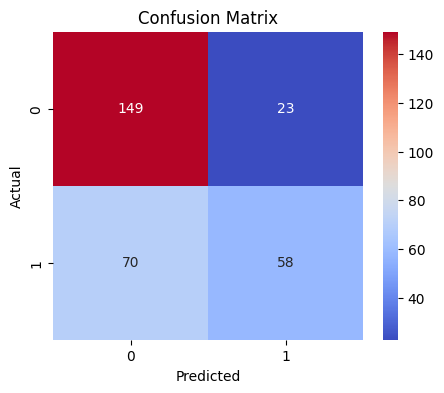

In [5]:

# --- VISUALIZATIONS ---

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="coolwarm", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


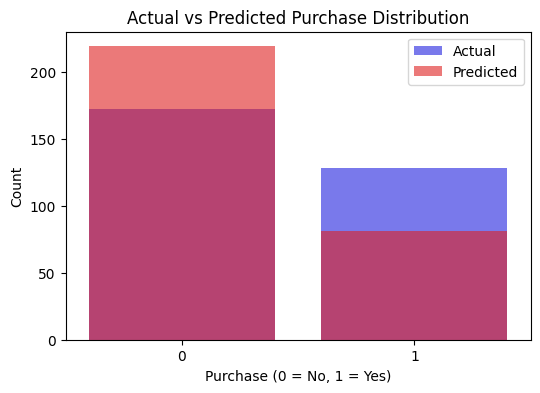

In [6]:

#  Actual vs. Predicted Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y_test, label="Actual", color="blue", alpha=0.6)
sns.countplot(x=y_pred, label="Predicted", color="red", alpha=0.6)
plt.legend()
plt.xlabel("Purchase (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.title("Actual vs Predicted Purchase Distribution")
plt.show()


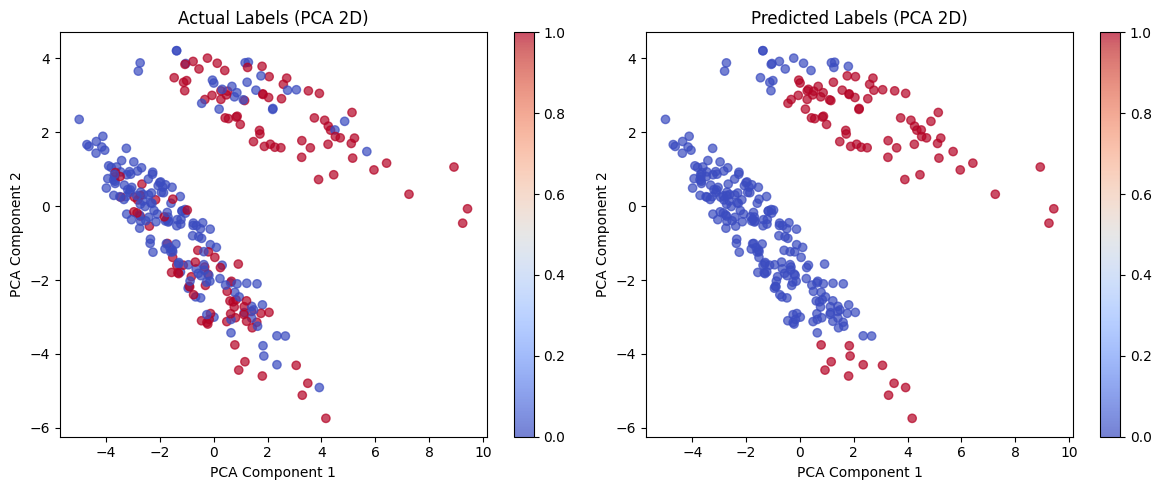

In [7]:

#  PCA 2D Visualization (Actual vs. Predicted)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Actual Labels
scatter1 = ax[0].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="coolwarm", alpha=0.7)
ax[0].set_title("Actual Labels (PCA 2D)")
ax[0].set_xlabel("PCA Component 1")
ax[0].set_ylabel("PCA Component 2")
plt.colorbar(scatter1, ax=ax[0])

# Predicted Labels
scatter2 = ax[1].scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap="coolwarm", alpha=0.7)
ax[1].set_title("Predicted Labels (PCA 2D)")
ax[1].set_xlabel("PCA Component 1")
ax[1].set_ylabel("PCA Component 2")
plt.colorbar(scatter2, ax=ax[1])

plt.tight_layout()
plt.show()


In [8]:
# Function to test model with manual input
def test_model():
    print("\n🔹 Enter customer details (Example values provided):")
    
    # Manually enter input values (modify as per dataset features)
    input_data = []
    feature_names = list(df.drop(columns=["PurchaseStatus"]).columns)

    # Example values for each feature (modify based on dataset)
    example_values = {
        "Age": 30,
        "AnnualIncome": 50000,
        "WebsiteVisits": 5,
        "TimeSpentOnWebsite": 12.5,
        "PreviousPurchases": 2,
        "Gender" : 0 or 1
    }

    for feature in feature_names:
        example = example_values.get(feature, 10)  # Default example if not listed
        value = float(input(f"Enter {feature} (e.g., {example}): "))
        input_data.append(value)

    # Convert to numpy array & reshape
    input_array = np.array(input_data).reshape(1, -1)

    # Apply the same preprocessing steps: Polynomial Features, Scaling & PCA
    input_poly = poly.transform(input_array)
    input_scaled = scaler.transform(input_poly)
    input_pca = pca.transform(input_scaled)

    # Predict using trained model
    prediction = best_svm.predict(input_pca)

    # Display result
    result = "✅ Customer WILL purchase" if prediction[0] == 1 else "❌ Customer WILL NOT purchase"
    print("\n🔹 Prediction Result:", result)

# Run the function to test model
test_model()



🔹 Enter customer details (Example values provided):


Enter Age (e.g., 30):  20
Enter Gender (e.g., 1):  1
Enter AnnualIncome (e.g., 50000):  51000
Enter NumberOfPurchases (e.g., 10):  1
Enter ProductCategory (e.g., 10):  3
Enter TimeSpentOnWebsite (e.g., 12.5):  12.5
Enter LoyaltyProgram (e.g., 10):  10
Enter DiscountsAvailed (e.g., 10):  0



🔹 Prediction Result: ✅ Customer WILL purchase


C:\Users\tarul\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
